### __Load Environment Variables__

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### __Research Agent__

In [2]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)

web_search_results = web_search.invoke("Nhiệt độ ở Việt Nam như nào?")

print(web_search_results["results"][0]["content"])

Việt Nam nằm trong vùng khí hậu nhiệt đới gió mùa. Nhiệt độ ở Việt Nam thường dao động trong khoảng 21 đến 35 độ C quanh năm. Độ ẩm trung bình trong năm vào


In [3]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="gpt-4o-mini",
    tools=[web_search],
    prompt=(
        "Bạn là một chuyên viên nghiên cứu (research agent).\n\n"
        "HƯỚNG DẪN:\n"
        "- CHỈ hỗ trợ các nhiệm vụ liên quan đến nghiên cứu, TUYỆT ĐỐI KHÔNG thực hiện tính toán (math).\n"
        "- Sau khi hoàn thành nhiệm vụ, hãy báo cáo trực tiếp lại cho người giám sát (supervisor).\n"
        "- CHỈ trả về kết quả công việc của bạn, KHÔNG bao gồm bất kỳ nội dung văn bản thừa nào khác."
    ),
    name="research_agent",
)

In [4]:
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)

def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [5]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "Ai là thị trưởng của thành phố New York?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_iwf8CbwqKju6NzTgPpOZm6yg)
 Call ID: call_iwf8CbwqKju6NzTgPpOZm6yg
  Args:
    query: current mayor of New York City
    search_depth: basic


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current mayor of New York City", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/Mayor_of_New_York_City", "title": "Mayor of New York City - Wikipedia", "content": "The current mayor is Zohran Mamdani, who was elected on November 4, 2025, and took office shortly after midnight on January 1, 2026.", "score": 0.95176035, "raw_content": null}, {"url": "https://www.nyc.gov/mayors-office", "title": "Official Site of NYC Mayor Zohran Mamdani - NYC Mayor's Office", "content": "Zohran Mamdani was s

### __Math Agent__

In [6]:
def add(a: float, b: float):
    """Cộng hai số"""
    return a + b


def multiply(a: float, b: float):
    """Nhân hai số"""
    return a * b


def divide(a: float, b: float):
    """Chia hai số"""
    return a / b


math_agent = create_react_agent(
    model="gpt-4o-mini",
    tools=[add, multiply, divide],
    prompt=(
        "Bạn là một chuyên viên toán học (math agent).\n\n"
        "HƯỚNG DẪN:\n"
        "- CHỈ hỗ trợ các nhiệm vụ liên quan đến toán học.\n"
        "- Sau khi hoàn thành nhiệm vụ, hãy báo cáo trực tiếp lại cho người giám sát (supervisor).\n"
        "- CHỈ trả về kết quả công việc của bạn, KHÔNG bao gồm bất kỳ nội dung văn bản thừa nào khác."
    ),
    name="math_agent",
)

In [7]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "Kết quả của phép tính (3 + 5) x 7 là bao nhiêu?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_JVYAIuOEkRPjsyUVxUMCH5F8)
 Call ID: call_JVYAIuOEkRPjsyUVxUMCH5F8
  Args:
    a: 3
    b: 5
  multiply (call_v1pabLTXmIotd900ugHm3gFl)
 Call ID: call_v1pabLTXmIotd900ugHm3gFl
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

Kết quả của phép tính (3 + 5) x 7 là 56.




### __Supervisor__

In [8]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("gpt-4o"),
    agents=[research_agent, math_agent],
    prompt=(
        "Bạn là một người giám sát (supervisor) quản lý hai nhân viên:\n"
        "- research_agent: Giao các nhiệm vụ liên quan đến nghiên cứu/tìm kiếm cho nhân viên này.\n"
        "- math_agent: Giao các nhiệm vụ liên quan đến toán học/tính toán cho nhân viên này.\n"
        "QUY TẮC:\n"
        "1. Chỉ giao việc cho TỪNG nhân viên một, không gọi song song.\n"
        "2. Tuyệt đối không tự mình thực hiện công việc, hãy giao cho nhân viên.\n"
        "3. Khi đã có đủ kết quả từ nhân viên, hãy trả lời người dùng cuối cùng."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

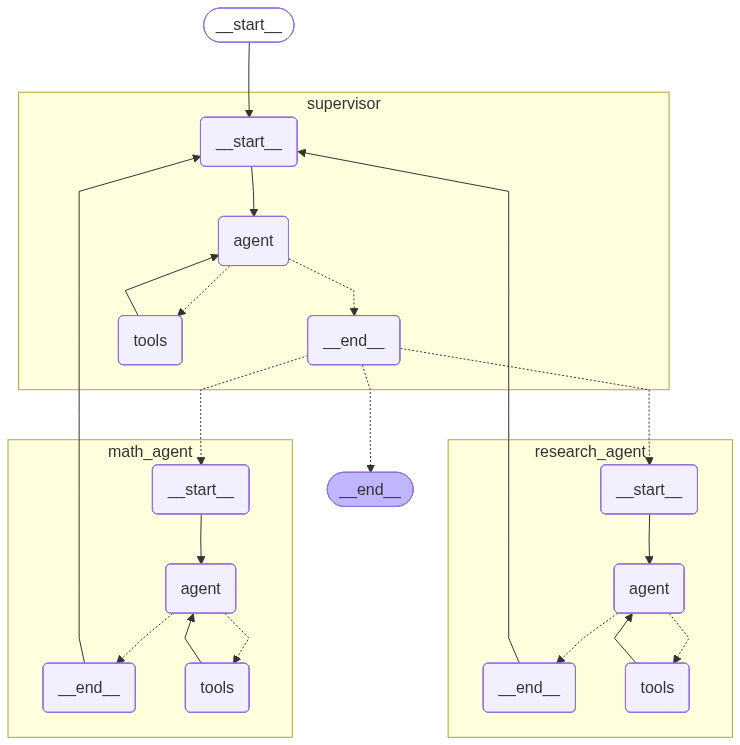

In [10]:
from IPython.display import display, Image

display(Image(supervisor.get_graph(xray=True).draw_mermaid_png()))

In [11]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Hãy tìm GDP của Việt Nam năm 2023 và 2024, sau đó tính toán tỷ lệ tăng/giảm phần trăm giữa hai năm này?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

GDP của Việt Nam năm 2023 là 433,008 triệu USD và năm 2024 là 459,472 triệu USD. Tỷ lệ tăng phần trăm GDP 